In [2]:
pip install mplfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.3 MB/s eta 0:00:00


In [3]:
# Necessary imports for this project
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import mplfinance as mpf
import warnings
from IPython.display import display # Import the display function

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [4]:
# Loading the newly uploaded data
file_path = 'bitcoin_2017-09-07_2024-09-15.csv'
btc_df = pd.read_csv(file_path)

# Displaying the first few rows to understand its structure
btc_df.head()


,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2017-09-07,2017-09-08,4597.12,4655.04,4491.33,4603.03,1.932914e+09,7.558147e+10
1,2017-09-08,2017-09-09,4599.88,4661.00,4075.18,4224.81,1.993160e+09,7.374856e+10
2,2017-09-09,2017-09-10,4228.75,4308.82,4114.11,4232.76,2.366425e+09,6.979280e+10
3,2017-09-10,2017-09-11,4226.06,4245.44,3951.04,4122.58,1.517856e+09,6.803915e+10
4,2017-09-11,2017-09-12,4122.94,4261.67,4099.40,4163.20,1.617782e+09,6.898337e+10


In [5]:
# Function to identify the trend using a simple moving average (SMA)
def get_trend(prices, window=5):
    sma = prices.rolling(window=window).mean()
    trend = ["neutral"]  # Initialize the first entry as neutral

    for i in range(1, len(prices)):
        if sma[i] > sma[i - 1]:  # SMA is increasing
            trend.append("uptrend")
        elif sma[i] < sma[i - 1]:  # SMA is decreasing
            trend.append("downtrend")
        else:
            trend.append("neutral")

    return trend

# Calculate the trend based on the 'Close' prices
btc_df['Trend'] = get_trend(btc_df['Close'])

# Function to identify candlestick patterns with prioritized order
def identify_candlestick_patterns(df):
    patterns = ['Unknown'] * len(df)  # Initialize the entire patterns list with 'Unknown' for each row
    locked = [False] * len(df)  # Track whether a candle is "locked" by a multi-candle pattern

    for i in range(2, len(df)):
        open_price = df['Open'][i]
        close_price = df['Close'][i]
        high_price = df['High'][i]
        low_price = df['Low'][i]
        prev_open = df['Open'][i - 1]
        prev_close = df['Close'][i - 1]
        trend = df['Trend'][i]

        # Body size and wick calculations
        body_size = abs(close_price - open_price)
        upper_wick = high_price - max(open_price, close_price)
        lower_wick = min(open_price, close_price) - low_price
        candle_range = high_price - low_price

        # **Apply patterns in the requested order**

        # 1. Three Black Crows
        if i >= 2 and df['Trend'][i-2] == "uptrend" and close_price < open_price and df['Close'][i-1] < df['Open'][i-1] and \
           df['Close'][i-2] < df['Open'][i-2] and df['Open'][i] < df['Close'][i-1] and df['Open'][i-1] < df['Close'][i-2] and \
           close_price < df['Close'][i-1] and not locked[i-2] and not locked[i-1] and not locked[i]:
                patterns[i-2] = 'THREE BLACK CROWS'
                patterns[i-1] = 'THREE BLACK CROWS'
                patterns[i] = 'THREE BLACK CROWS'
                locked[i-2] = locked[i-1] = locked[i] = True
        # 2. Three White Soldiers
        elif i >= 2 and df['Trend'][i-2] == "downtrend" and close_price > open_price and df['Close'][i-1] > df['Open'][i-1] and \
             df['Close'][i-2] > df['Open'][i-2] and df['Open'][i] > df['Close'][i-1] and df['Open'][i-1] > df['Close'][i-2] and \
             close_price > df['Close'][i-1] and not locked[i-2] and not locked[i-1] and not locked[i]:
                patterns[i-2] = 'THREE WHITE SOLDIERS'
                patterns[i-1] = 'THREE WHITE SOLDIERS'
                patterns[i] = 'THREE WHITE SOLDIERS'
                locked[i-2] = locked[i-1] = locked[i] = True

        # 3. Morning Doji Star
        elif i >= 2 and df['Trend'][i-1] == "downtrend" and abs(prev_close - prev_open) <= (df['High'][i-1] - df['Low'][i-1]) * 0.1 and \
             close_price > open_price and close_price > (df['Close'][i-2] + df['Open'][i-2]) / 2 and df['Close'][i-2] < df['Open'][i-2] and \
             not locked[i-2] and not locked[i-1] and not locked[i]:
                patterns[i-2] = 'MORNING DOJI STAR'
                patterns[i-1] = 'MORNING DOJI STAR'
                patterns[i] = 'MORNING DOJI STAR'
                locked[i-2] = locked[i-1] = locked[i] = True

        # 4. Evening Doji Star
        elif i >= 2 and df['Trend'][i-1] == "uptrend" and abs(prev_close - prev_open) <= (df['High'][i-1] - df['Low'][i-1]) * 0.1 and \
             close_price < open_price and close_price < (df['Close'][i-2] + df['Open'][i-2]) / 2 and df['Close'][i-2] > df['Open'][i-2] and \
             not locked[i-2] and not locked[i-1] and not locked[i]:
                patterns[i-2] = 'EVENING DOJI STAR'
                patterns[i-1] = 'EVENING DOJI STAR'
                patterns[i] = 'EVENING DOJI STAR'
                locked[i-2] = locked[i-1] = locked[i] = True
        # 5. Morning Star
        elif i >= 2 and df['Trend'][i-1] == "downtrend" and close_price > open_price and df['Close'][i-2] < df['Open'][i-2] and \
             close_price > (df['Close'][i-2] + df['Open'][i-2]) / 2 and not locked[i-2] and not locked[i-1] and not locked[i]:
                patterns[i-2] = 'MORNING STAR'
                patterns[i-1] = 'MORNING STAR'
                patterns[i] = 'MORNING STAR'
                locked[i-2] = locked[i-1] = locked[i] = True
        # 6. Evening Star
        elif i >= 2 and df['Trend'][i-1] == "uptrend" and close_price < open_price and df['Close'][i-2] > df['Open'][i-2] and \
             close_price < (df['Close'][i-2] + df['Open'][i-2]) / 2 and not locked[i-2] and not locked[i-1] and not locked[i]:
                patterns[i-2] = 'EVENING STAR'
                patterns[i-1] = 'EVENING STAR'
                patterns[i] = 'EVENING STAR'
                locked[i-2] = locked[i-1] = locked[i] = True
        # 7. Bearish Engulfing
        elif df['Trend'][i-1] == "uptrend" and close_price < open_price and open_price > prev_close and close_price < prev_open and \
             abs(close_price - open_price) > abs(prev_open - prev_close) and not locked[i-1] and not locked[i]:
                patterns[i-1] = 'BEARISH ENGULFING'
                patterns[i] = 'BEARISH ENGULFING'
                locked[i-1] = locked[i] = True
        # 8. Bullish Engulfing
        elif df['Trend'][i-1] == "downtrend" and close_price > open_price and open_price < prev_close and close_price > prev_open and \
             abs(close_price - open_price) > abs(prev_close - prev_open) and not locked[i-1] and not locked[i]:
                patterns[i-1] = 'BULLISH ENGULFING'
                patterns[i] = 'BULLISH ENGULFING'
                locked[i-1] = locked[i] = True
        # 9. Dark Cloud Cover
        elif df['Trend'][i-1] == "uptrend" and close_price < open_price and open_price > prev_close and \
             close_price < (prev_open + prev_close) / 2 and not locked[i-1] and not locked[i]:
                patterns[i-1] = 'DARK CLOUD COVER'
                patterns[i] = 'DARK CLOUD COVER'
                locked[i-1] = locked[i] = True

        # 10. Piercing Line
        elif df['Trend'][i-1] == "downtrend" and close_price > open_price and open_price < prev_close and \
             close_price > (prev_open + prev_close) / 2 and not locked[i-1] and not locked[i]:
                patterns[i-1] = 'PIERCING LINE'
                patterns[i] = 'PIERCING LINE'
                locked[i-1] = locked[i] = True
        # 11. Dragonfly Doji
        elif body_size <= candle_range * 0.1 and lower_wick >= 2 * body_size and upper_wick <= candle_range * 0.1 and not locked[i]:
            patterns[i] = 'Dragonfly Doji'

        # 12. Gravestone Doji
        elif body_size <= candle_range * 0.1 and upper_wick >= 2 * body_size and lower_wick <= candle_range * 0.1 and not locked[i]:
            patterns[i] = 'Gravestone Doji'

        # 11. Inverted Hammer
        elif df['Trend'][i-1] == "downtrend" and body_size <= candle_range * 0.3 and upper_wick >= 2 * body_size and lower_wick <= body_size * 0.1 and not locked[i]:
            patterns[i] = 'INVERTED HAMMER'

        # 12. Shooting Star
        elif df['Trend'][i-1] == "uptrend" and body_size <= candle_range * 0.3 and upper_wick >= 2 * body_size and lower_wick <= body_size * 0.1 and not locked[i]:
            patterns[i] = 'SHOOTING STAR'

        # 13. Hammer
        elif df['Trend'][i-1] == "downtrend" and body_size <= candle_range * 0.3 and lower_wick >= 2 * body_size and upper_wick <= body_size * 0.1 and not locked[i]:
            patterns[i] = 'HAMMER'

        # 14. Hanging Man
        elif df['Trend'][i-1] == "uptrend" and body_size <= candle_range * 0.3 and lower_wick >= 2 * body_size and upper_wick <= body_size * 0.1 and not locked[i]:
            patterns[i] = 'HANGING MAN'

        # 17. Doji
        elif body_size <= candle_range * 0.1 and not locked[i]:
            patterns[i] = 'DOJI'

        # 18. Spinning Top
        elif body_size <= candle_range * 0.3 and upper_wick > body_size and lower_wick > body_size and not locked[i]:
            patterns[i] = 'SPINNING TOP'

    return patterns

# Updating the DataFrame with the new pattern labels
btc_df['Candlestick Pattern'] = identify_candlestick_patterns(btc_df)

# Displaying the updated DataFrame to the user
btc_df.head()
btc_df.to_csv('refined_candlestick_patterns.csv', index=False)


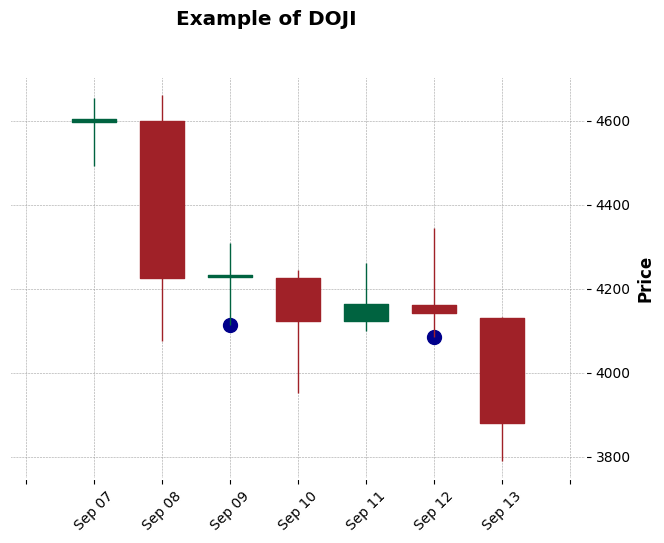

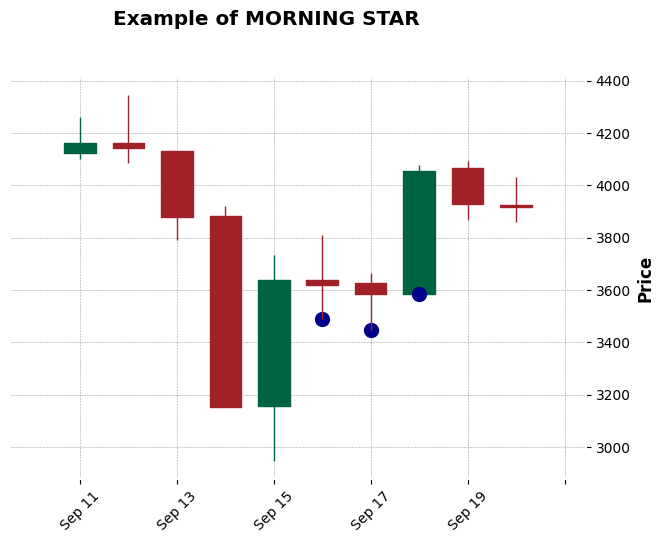

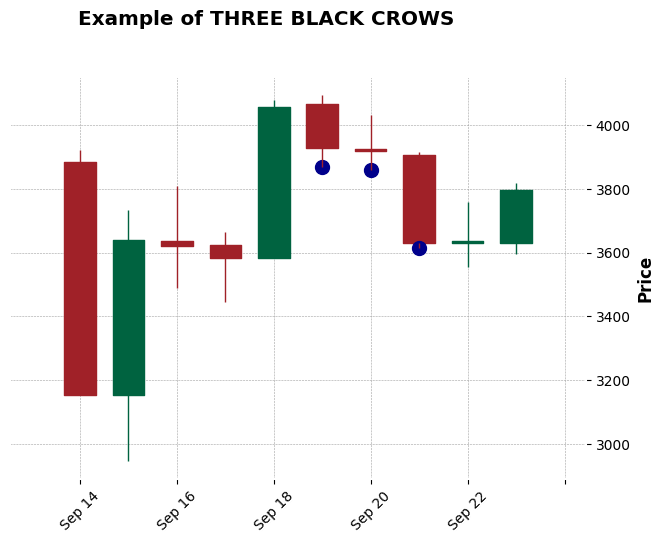

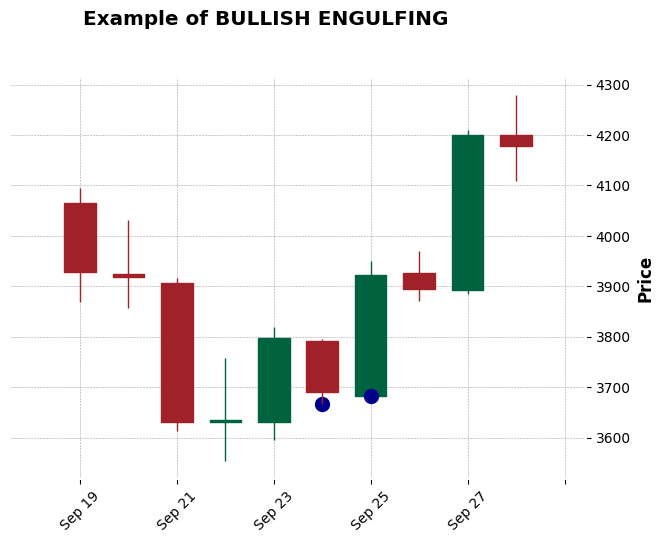

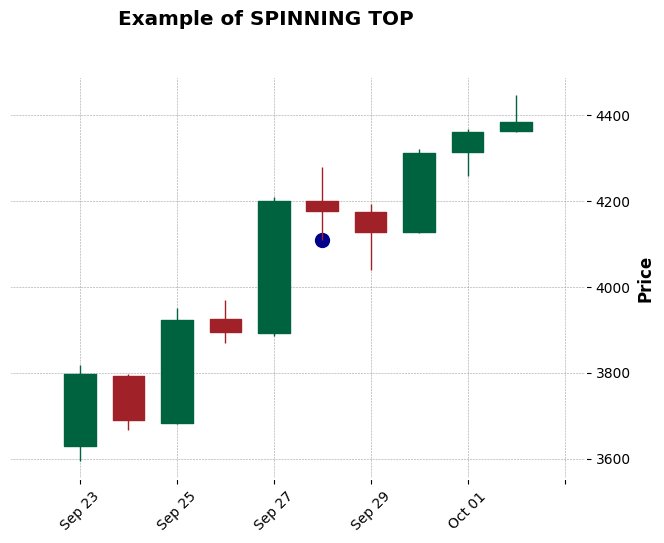

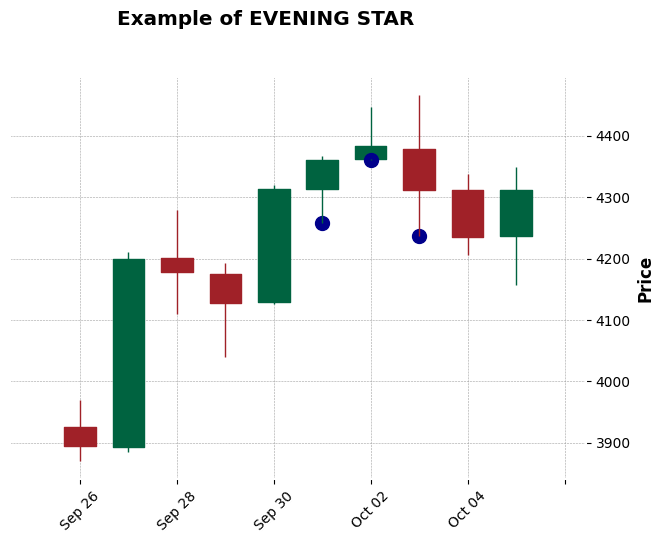

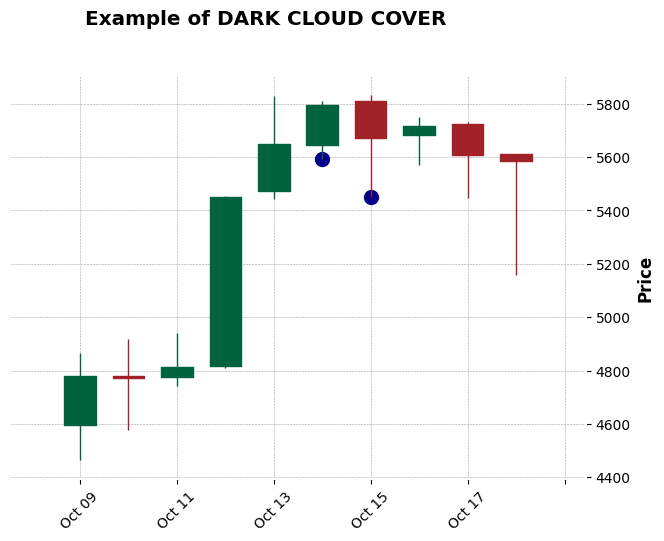

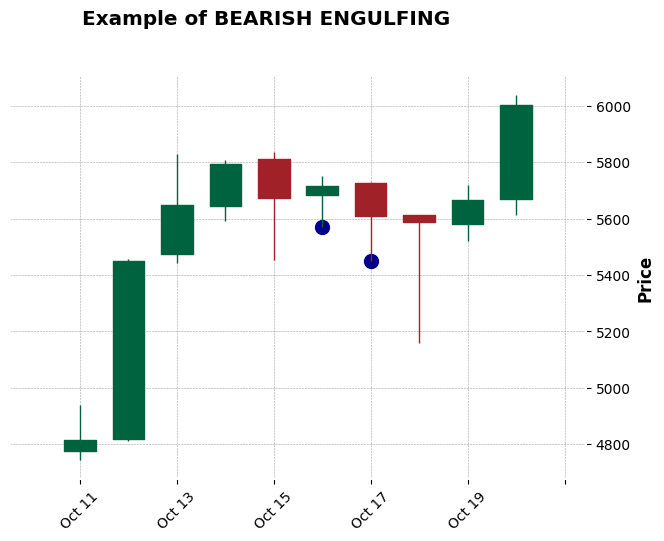

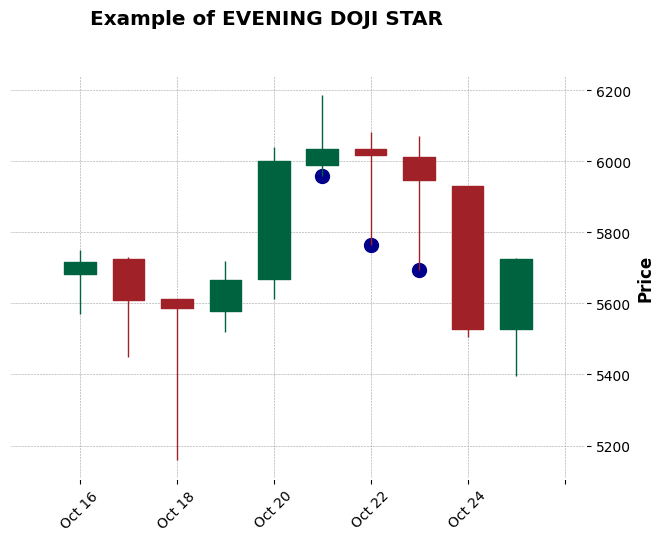

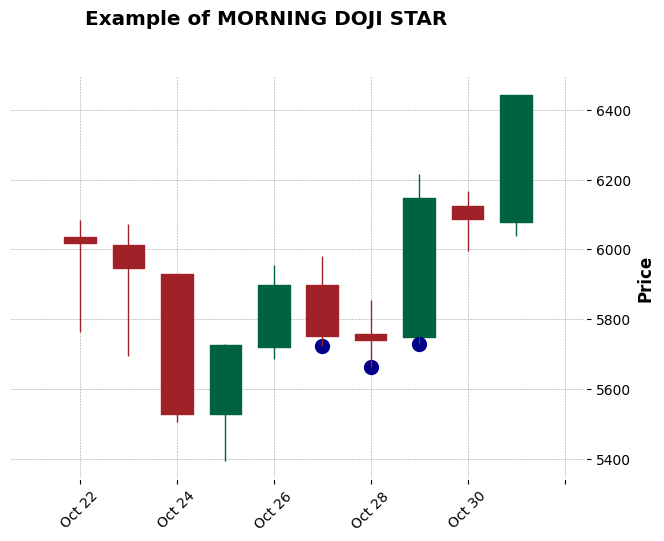

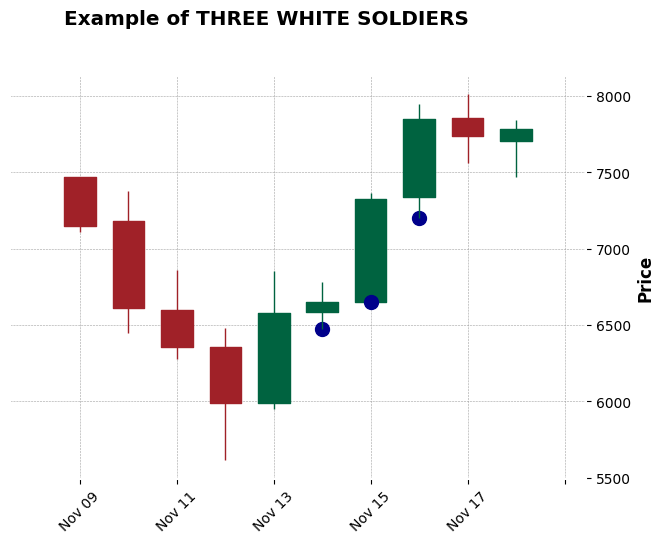

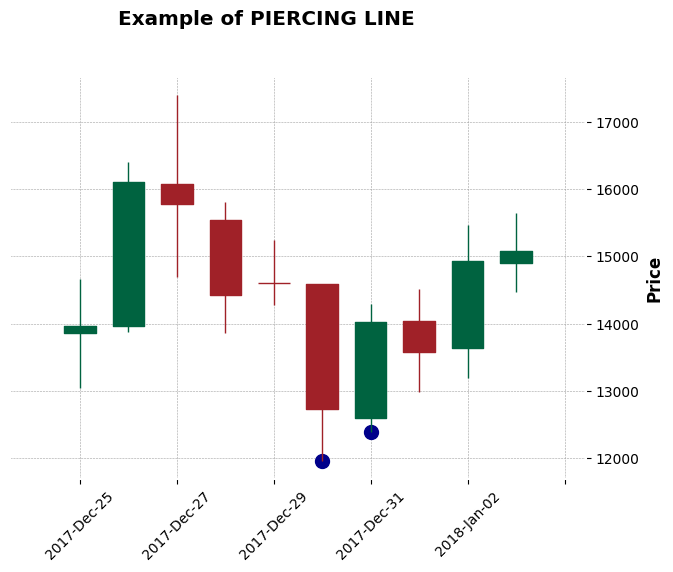

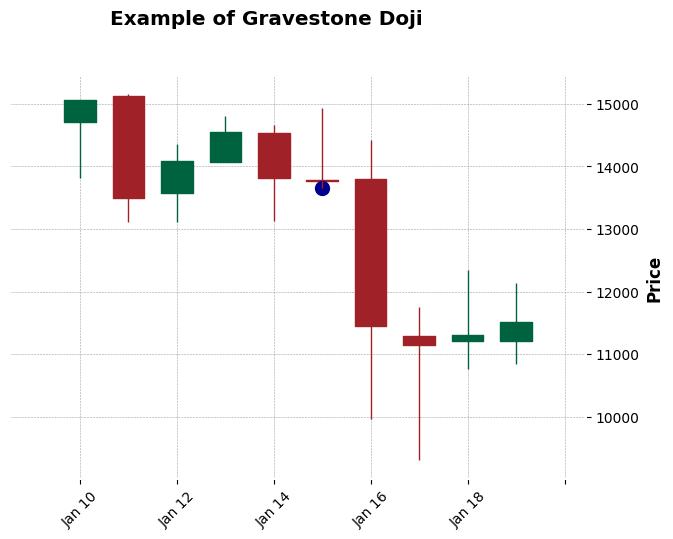

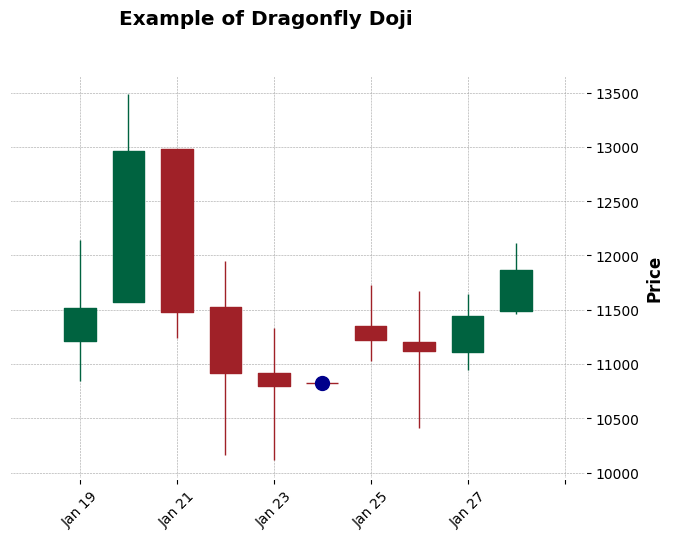

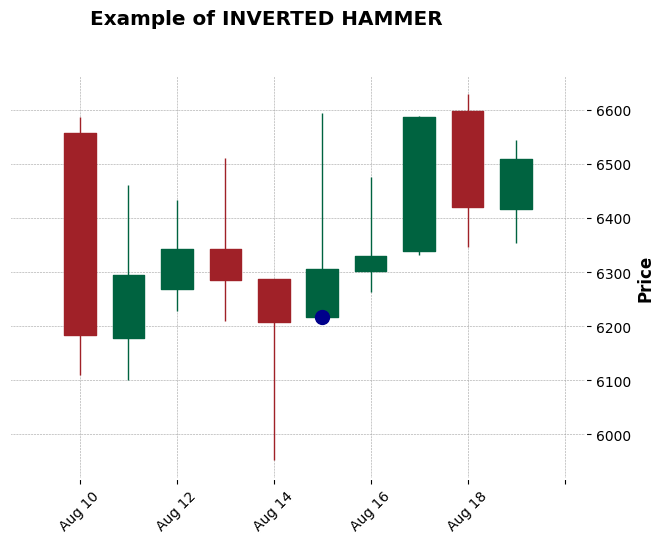

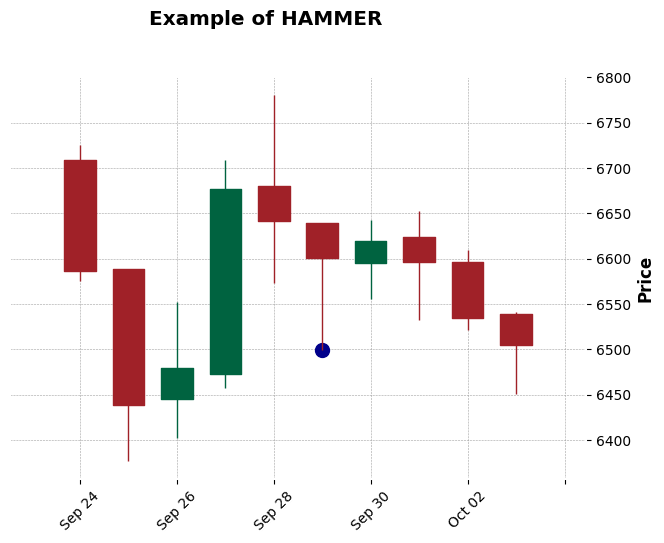

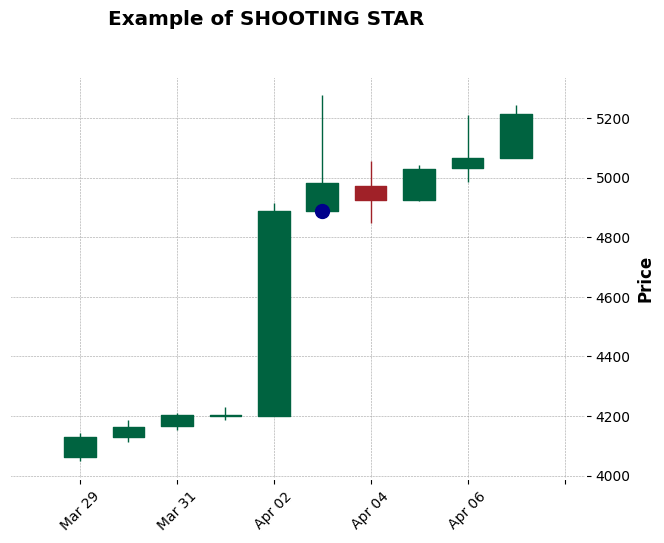

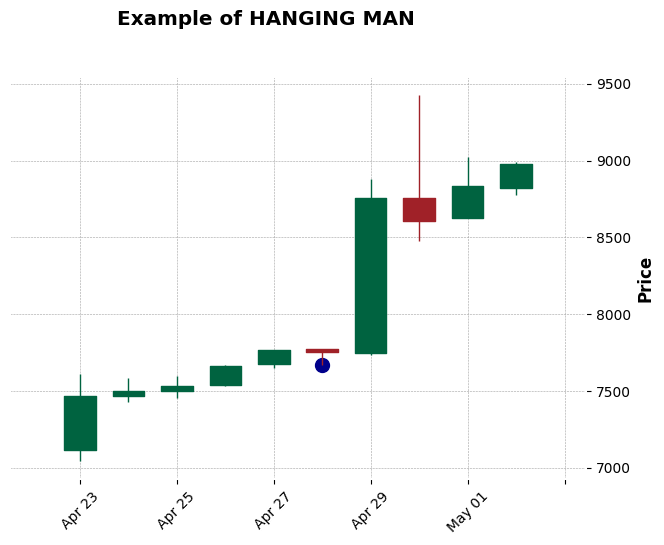

In [6]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

# Function to visualize one example of each pattern in the dataset
def plot_candlestick_examples(df):
    unique_patterns = df['Candlestick Pattern'].unique()

    for pattern_label in unique_patterns:
        # Skip "Unknown" patterns for plotting clarity
        if pattern_label == 'Unknown':
            continue

        # Select one example of the current pattern
        examples = df[df['Candlestick Pattern'] == pattern_label]
        if not examples.empty:
            example_index = examples.index[0]

            # Define a window around the pattern to provide context
            start_index = max(0, example_index - 5)
            end_index = min(len(df), example_index + 5)

            # Extract the data for plotting
            plot_data = df.iloc[start_index:end_index].copy()
            plot_data.index = pd.to_datetime(plot_data['Start'])

            # Create a series for highlighting: np.nan for non-matching candles, the 'Low' value for matching candles
            highlight_values = [
                plot_data['Low'][idx] if plot_data['Candlestick Pattern'][idx] == pattern_label else np.nan
                for idx in plot_data.index
            ]

            # Create the addplot object to highlight the candles
            highlight = mpf.make_addplot(highlight_values, type='scatter', markersize=100, marker='o', color='darkblue')

            # Plotting the example with highlighted markers
            title = f"Example of {pattern_label}"
            mpf.plot(plot_data[['Open', 'High', 'Low', 'Close']], type='candle', style='charles', title=title, volume=False, addplot=highlight)
            plt.show()

# Visualize one example for each pattern in the labeled dataset
plot_candlestick_examples(btc_df)


In [7]:
btc_df["Candlestick Pattern"].value_counts()


,count
Candlestick Pattern,
Unknown,954
EVENING STAR,309
MORNING STAR,306
BULLISH ENGULFING,206
BEARISH ENGULFING,154
SPINNING TOP,153
DOJI,105
DARK CLOUD COVER,102
PIERCING LINE,84
